# Time series forecasting (using Facebook Prophet): Air quality (Bangkok)
* data source: https://aqicn.org/data-platform/register/
* Facebook Prophet: https://facebook.github.io/prophet/
* further reading: https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

In [1]:
from IPython.display import YouTubeVideo
# YouTubeVideo('', width=720, height=405)

In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


Timestamp('2021-03-15 08:06:48.771678')

## read and preprocess data

In [3]:
data_url='https://github.com/prasertcbs/basic-dataset/raw/master/bangkok-air-quality.csv'
data=pd.read_csv(data_url, parse_dates=['date'], skipinitialspace=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2021-03-01,93.0,30.0,8.0,6.0,1.0,NaN
1,2021-03-02,68.0,27.0,7.0,5.0,1.0,NaN
2,2021-03-03,58.0,37.0,13.0,9.0,1.0,NaN
3,2021-03-04,74.0,35.0,13.0,6.0,NaN,NaN
4,2021-03-05,72.0,38.0,15.0,6.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
2620,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
2621,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
2622,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2624 non-null   datetime64[ns]
 1   pm25    1680 non-null   float64       
 2   pm10    2609 non-null   float64       
 3   o3      2610 non-null   float64       
 4   no2     2611 non-null   float64       
 5   so2     1877 non-null   float64       
 6   co      963 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.6 KB


In [5]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [6]:
y_col='pm25'

In [7]:
data.dropna(subset=[y_col], inplace=True)
data

,date,pm25,pm10,o3,no2,so2,co
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
5,2014-01-05,NaN,95.0,69.0,52.0,6.0,14.0
...,...,...,...,...,...,...,...
2618,2021-03-09,83.0,49.0,15.0,12.0,1.0,NaN
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN


In [8]:
df=data[['date', y_col]]
df.columns=['ds', 'y']
df

,ds,y
1,2014-01-01,84.0
2,2014-01-02,84.0
3,2014-01-03,103.0
4,2014-01-04,101.0
5,2014-01-05,95.0
...,...,...
2618,2021-03-09,49.0
2619,2021-03-10,53.0
2620,2021-03-11,52.0
2621,2021-03-12,48.0


## Time Series Forecasting with Prophet

In [9]:
# install facebook prophet (Time Series analysis)
# !conda install -c conda-forge fbprophet
# !pip install fbprophet

In [10]:
from fbprophet import Prophet

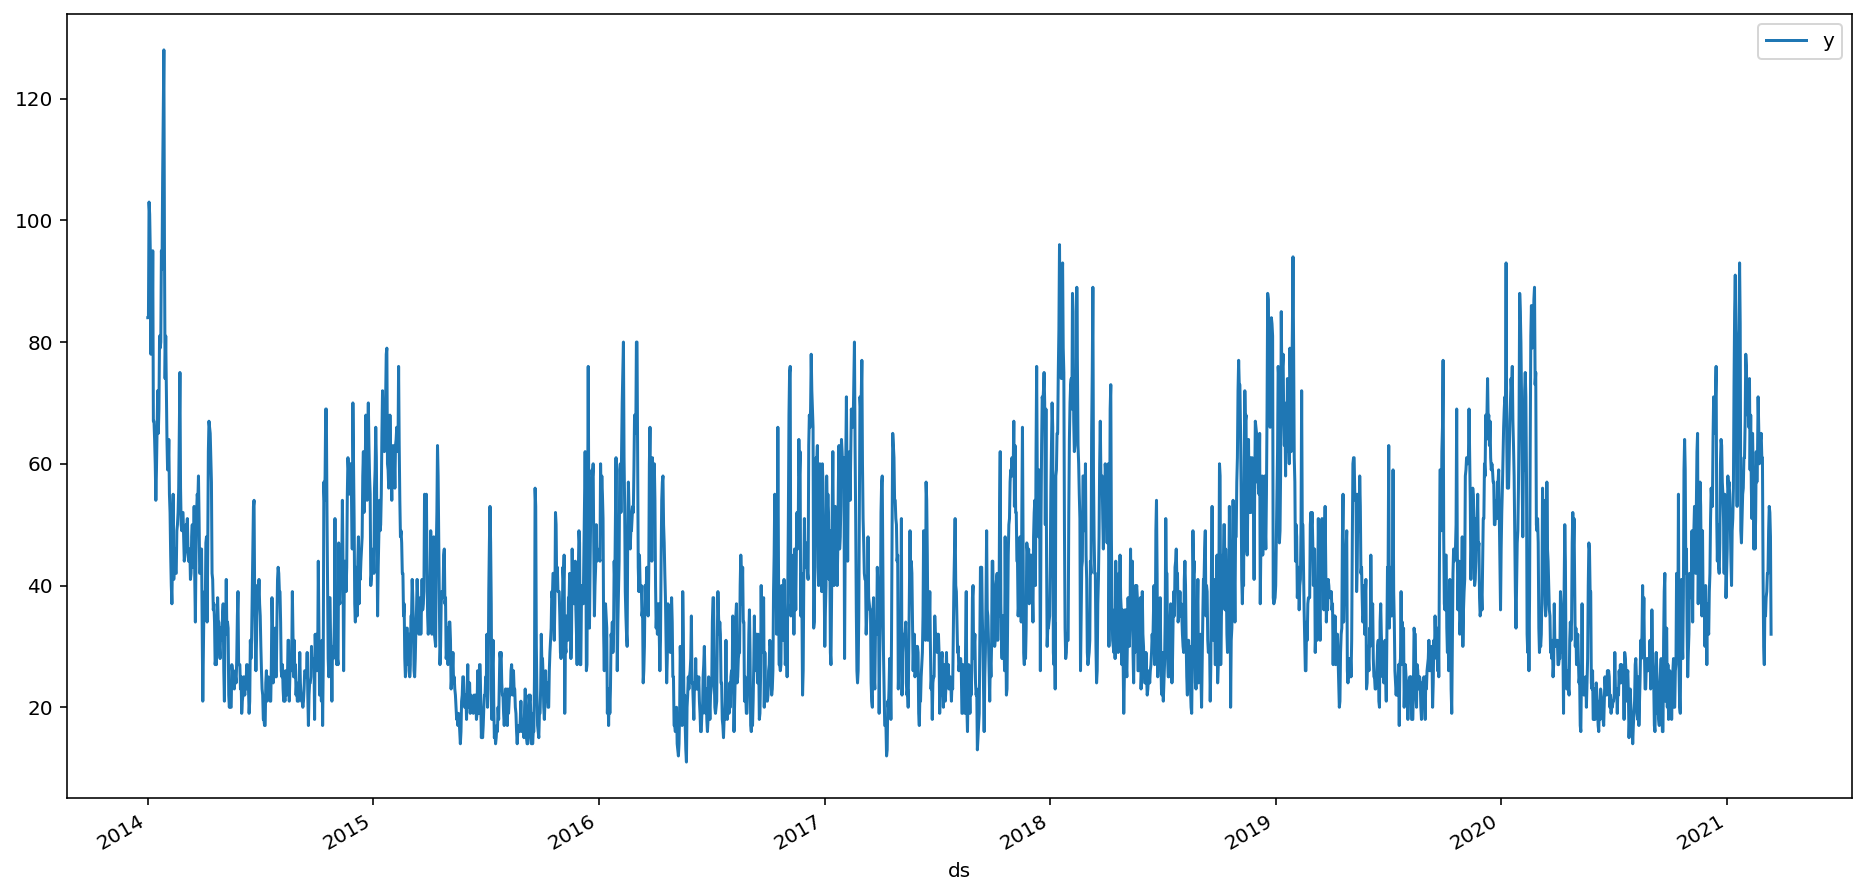

In [11]:
df.set_index('ds').plot(figsize=(16, 8));

In [12]:
model=Prophet()

In [13]:
model.__dict__

{'growth': 'linear',
 'changepoints': None,
 'n_changepoints': 25,
 'specified_changepoints': False,
 'changepoint_range': 0.8,
 'yearly_seasonality': 'auto',
 'weekly_seasonality': 'auto',
 'daily_seasonality': 'auto',
 'holidays': None,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10.0,
 'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 10.0,
 'mcmc_samples': 0,
 'interval_width': 0.8,
 'uncertainty_samples': 1000,
 'start': None,
 'y_scale': None,
 'logistic_floor': False,
 't_scale': None,
 'changepoints_t': None,
 'seasonalities': OrderedDict(),
 'extra_regressors': OrderedDict(),
 'country_holidays': None,
 'stan_fit': None,
 'params': {},
 'history': None,
 'history_dates': None,
 'train_component_cols': None,
 'component_modes': None,
 'train_holiday_names': None,
 'fit_kwargs': {},
 'stan_backend': <fbprophet.models.PyStanBackend at 0x22517d19188>}

In [14]:
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
df.tail()

,ds,y
2618,2021-03-09,49.0
2619,2021-03-10,53.0
2620,2021-03-11,52.0
2621,2021-03-12,48.0
2622,2021-03-13,32.0


### make_future_dataframe เพื่อใช้ในการทำ model.forecast ไปในอนาคต เช่น 180 วันจากข้อมูล

In [16]:
future=model.make_future_dataframe(periods=180, freq='D')
future.tail()

,ds
2784,2021-09-05
2785,2021-09-06
2786,2021-09-07
2787,2021-09-08
2788,2021-09-09


In [17]:
future.head()

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05


In [18]:
forecast=model.predict(future)

In [19]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,45.016803,46.653576,76.024389,45.016803,45.016803,16.072016,16.072016,16.072016,0.190890,0.190890,0.190890,15.881125,15.881125,15.881125,0.0,0.0,0.0,61.088819
1,2014-01-02,44.993254,47.260936,75.841678,44.993254,44.993254,16.432187,16.432187,16.432187,0.592287,0.592287,0.592287,15.839900,15.839900,15.839900,0.0,0.0,0.0,61.425441
2,2014-01-03,44.969706,45.989101,75.350599,44.969706,44.969706,16.313918,16.313918,16.313918,0.465109,0.465109,0.465109,15.848809,15.848809,15.848809,0.0,0.0,0.0,61.283623
3,2014-01-04,44.946157,45.370041,74.161579,44.946157,44.946157,14.856499,14.856499,14.856499,-1.054331,-1.054331,-1.054331,15.910830,15.910830,15.910830,0.0,0.0,0.0,59.802655
4,2014-01-05,44.922608,44.606562,74.530140,44.922608,44.922608,15.249956,15.249956,15.249956,-0.777548,-0.777548,-0.777548,16.027504,16.027504,16.027504,0.0,0.0,0.0,60.172564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,2021-09-05,36.071627,7.418618,35.972926,35.739825,36.500209,-14.410620,-14.410620,-14.410620,-0.777548,-0.777548,-0.777548,-13.633073,-13.633073,-13.633073,0.0,0.0,0.0,21.661006
2785,2021-09-06,36.065036,8.613586,37.386579,35.730975,36.500096,-13.255227,-13.255227,-13.255227,0.281267,0.281267,0.281267,-13.536493,-13.536493,-13.536493,0.0,0.0,0.0,22.809809
2786,2021-09-07,36.058445,8.608514,35.720165,35.722125,36.499284,-13.099574,-13.099574,-13.099574,0.302326,0.302326,0.302326,-13.401900,-13.401900,-13.401900,0.0,0.0,0.0,22.958871
2787,2021-09-08,36.051854,8.711362,38.184573,35.712317,36.497332,-13.038098,-13.038098,-13.038098,0.190890,0.190890,0.190890,-13.228989,-13.228989,-13.228989,0.0,0.0,0.0,23.013756


In [20]:
df

,ds,y
1,2014-01-01,84.0
2,2014-01-02,84.0
3,2014-01-03,103.0
4,2014-01-04,101.0
5,2014-01-05,95.0
...,...,...
2618,2021-03-09,49.0
2619,2021-03-10,53.0
2620,2021-03-11,52.0
2621,2021-03-12,48.0


In [21]:
dfcst=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
dfcst

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-01,61.088819,46.653576,76.024389
1,2014-01-02,61.425441,47.260936,75.841678
2,2014-01-03,61.283623,45.989101,75.350599
3,2014-01-04,59.802655,45.370041,74.161579
4,2014-01-05,60.172564,44.606562,74.530140
...,...,...,...,...
2784,2021-09-05,21.661006,7.418618,35.972926
2785,2021-09-06,22.809809,8.613586,37.386579
2786,2021-09-07,22.958871,8.608514,35.720165
2787,2021-09-08,23.013756,8.711362,38.184573


In [22]:
dt=pd.merge(df, dfcst, left_on='ds', right_on='ds')
dt

,ds,y,yhat,yhat_lower,yhat_upper
0,2014-01-01,84.0,61.088819,46.653576,76.024389
1,2014-01-02,84.0,61.425441,47.260936,75.841678
2,2014-01-03,103.0,61.283623,45.989101,75.350599
3,2014-01-04,101.0,59.802655,45.370041,74.161579
4,2014-01-05,95.0,60.172564,44.606562,74.530140
...,...,...,...,...,...
2604,2021-03-09,49.0,41.192131,25.775207,55.161580
2605,2021-03-10,53.0,40.682847,25.458133,55.335239
2606,2021-03-11,52.0,40.714766,26.387480,56.127787
2607,2021-03-12,48.0,40.249230,26.733107,54.250807


In [23]:
dt.shape

(2609, 5)

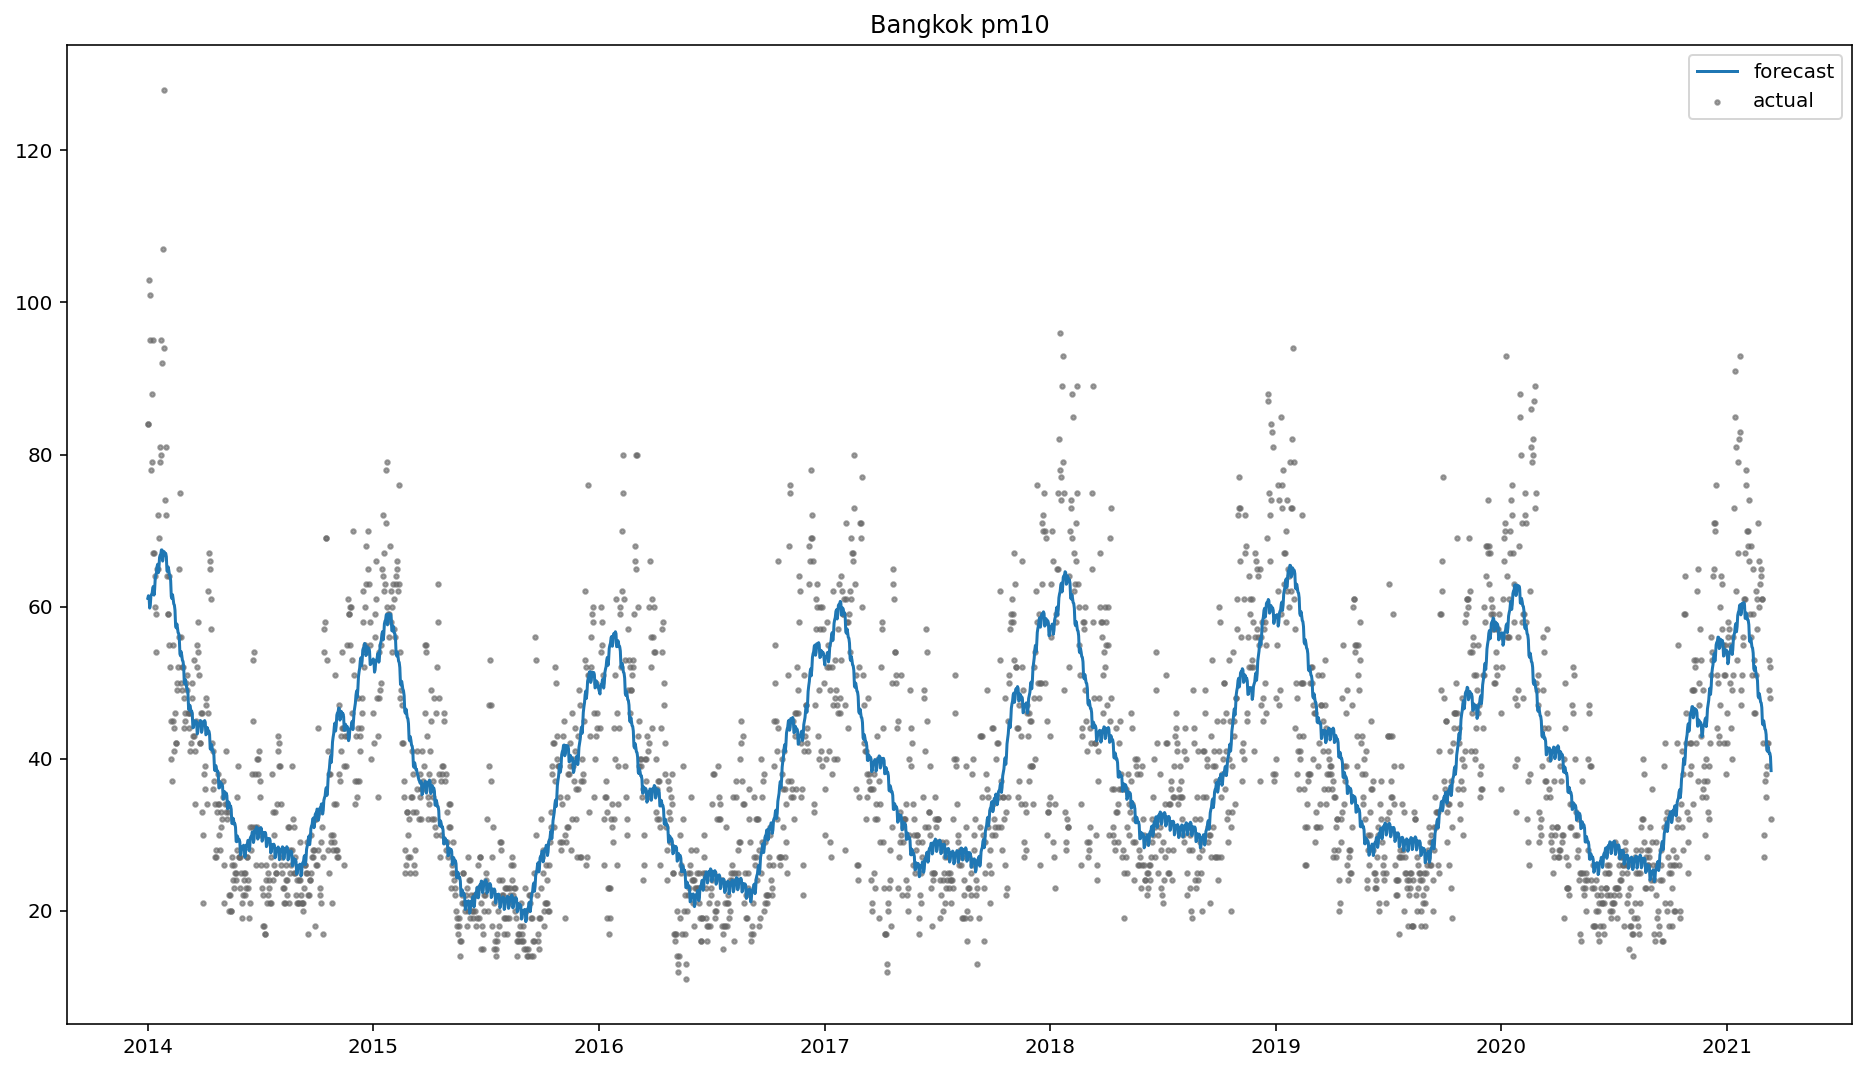

In [24]:
plt.figure(figsize=(16,9))
plt.scatter(dt['ds'], dt['y'], color='.4', label='actual', s=5, alpha=.6)
plt.plot(dt['ds'], dt['yhat'], label='forecast')
plt.title(f'Bangkok {y_col}')
plt.legend();

### plot actual (black dot) vs forcast (blue line)

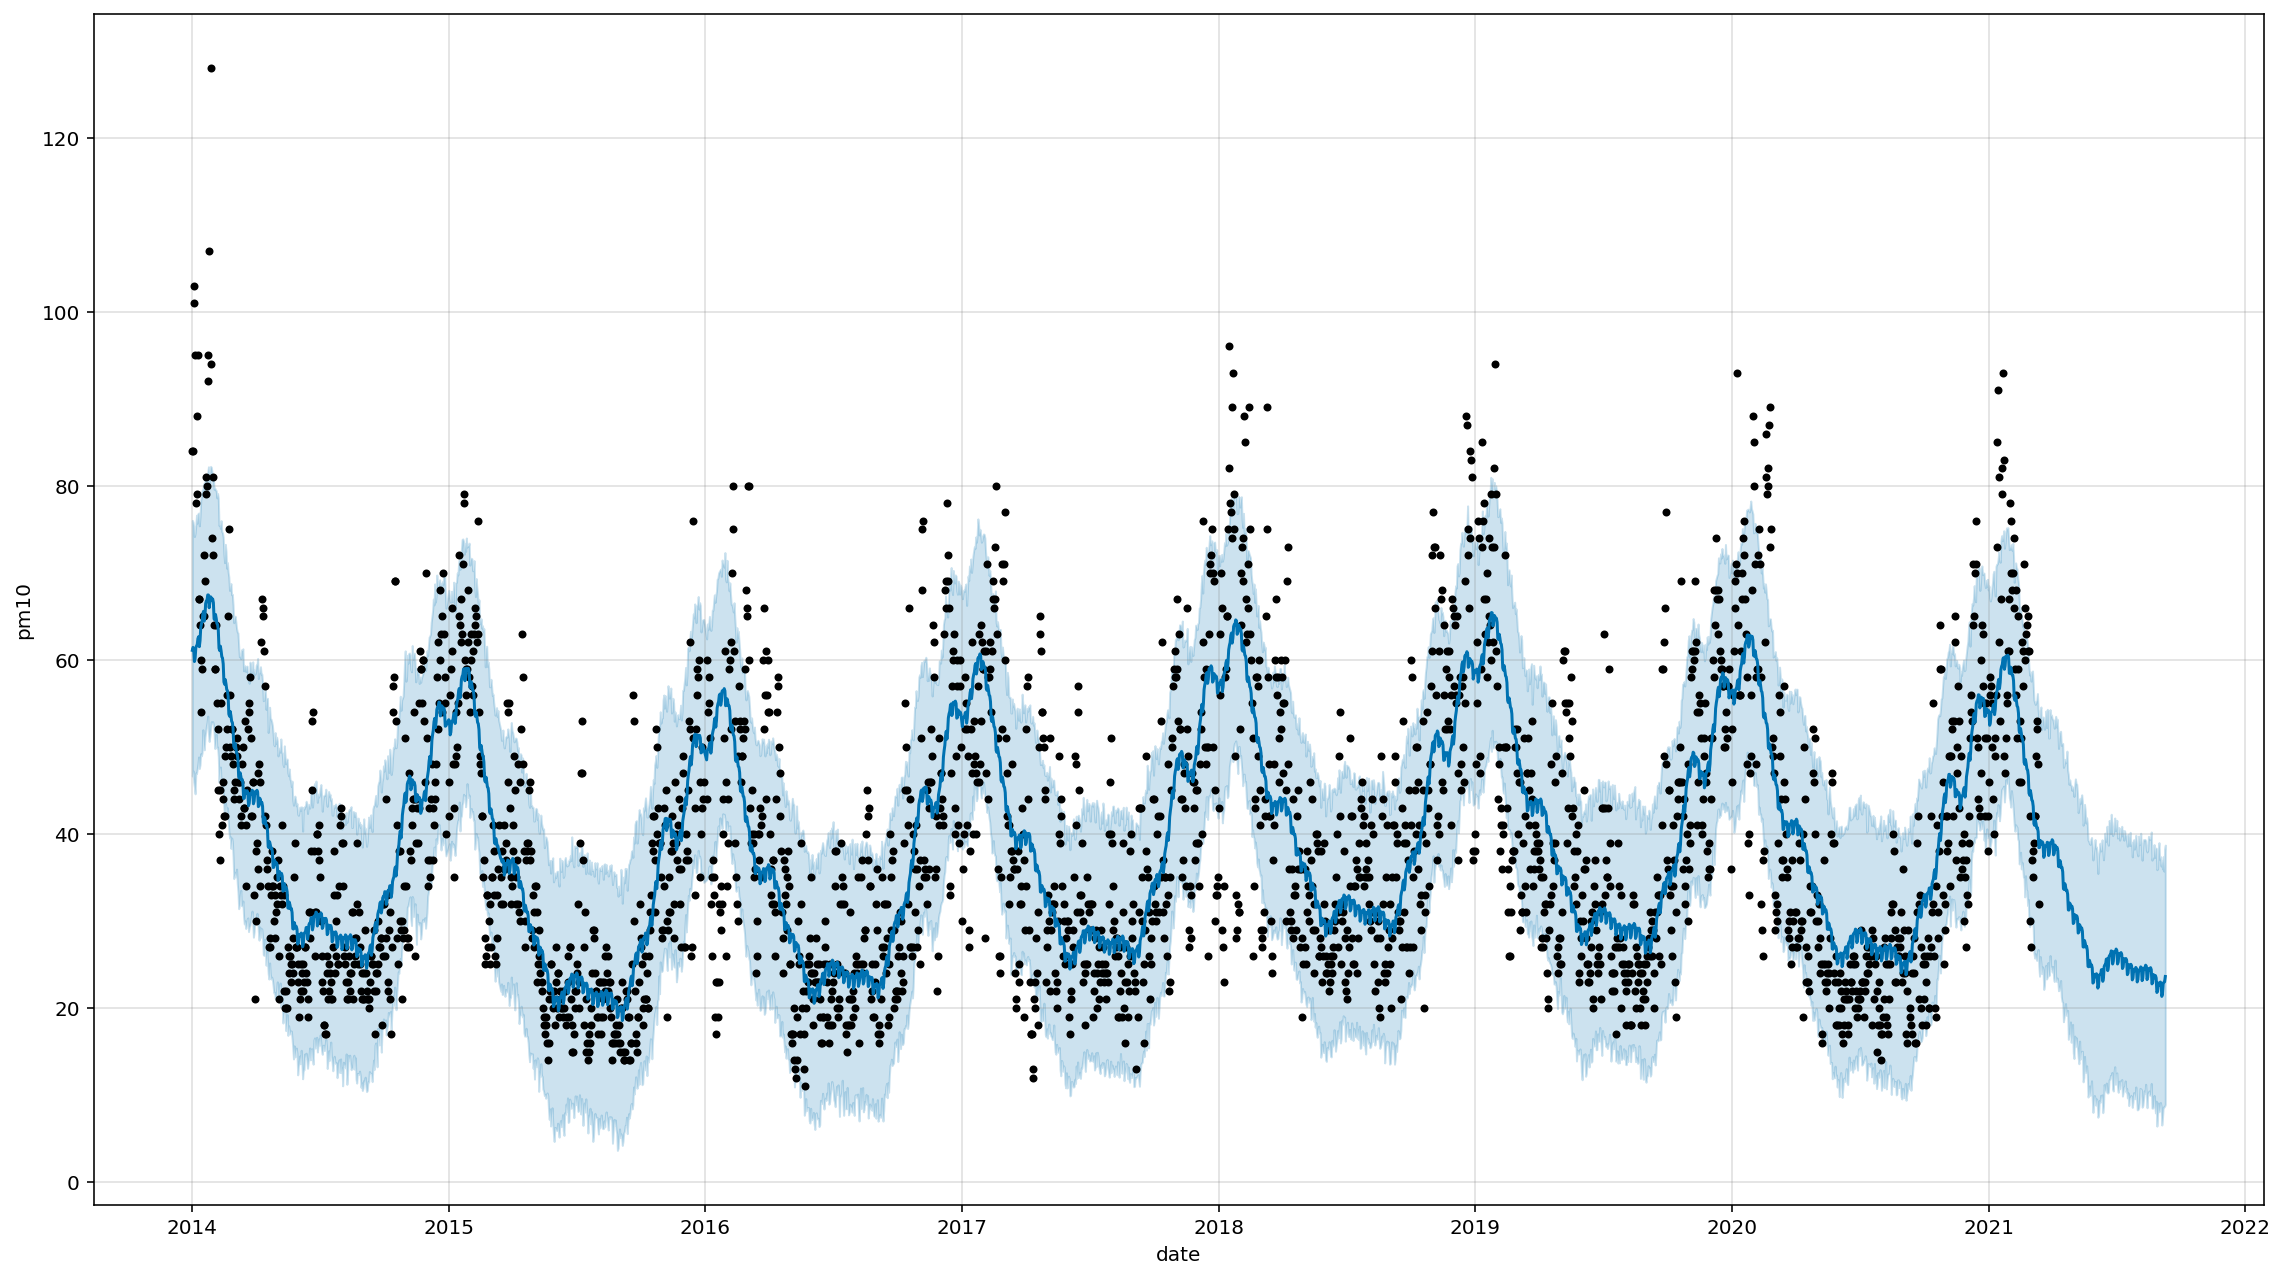

In [25]:
fig=model.plot(forecast, uncertainty=True, figsize=(16, 9), xlabel='date', ylabel=y_col)

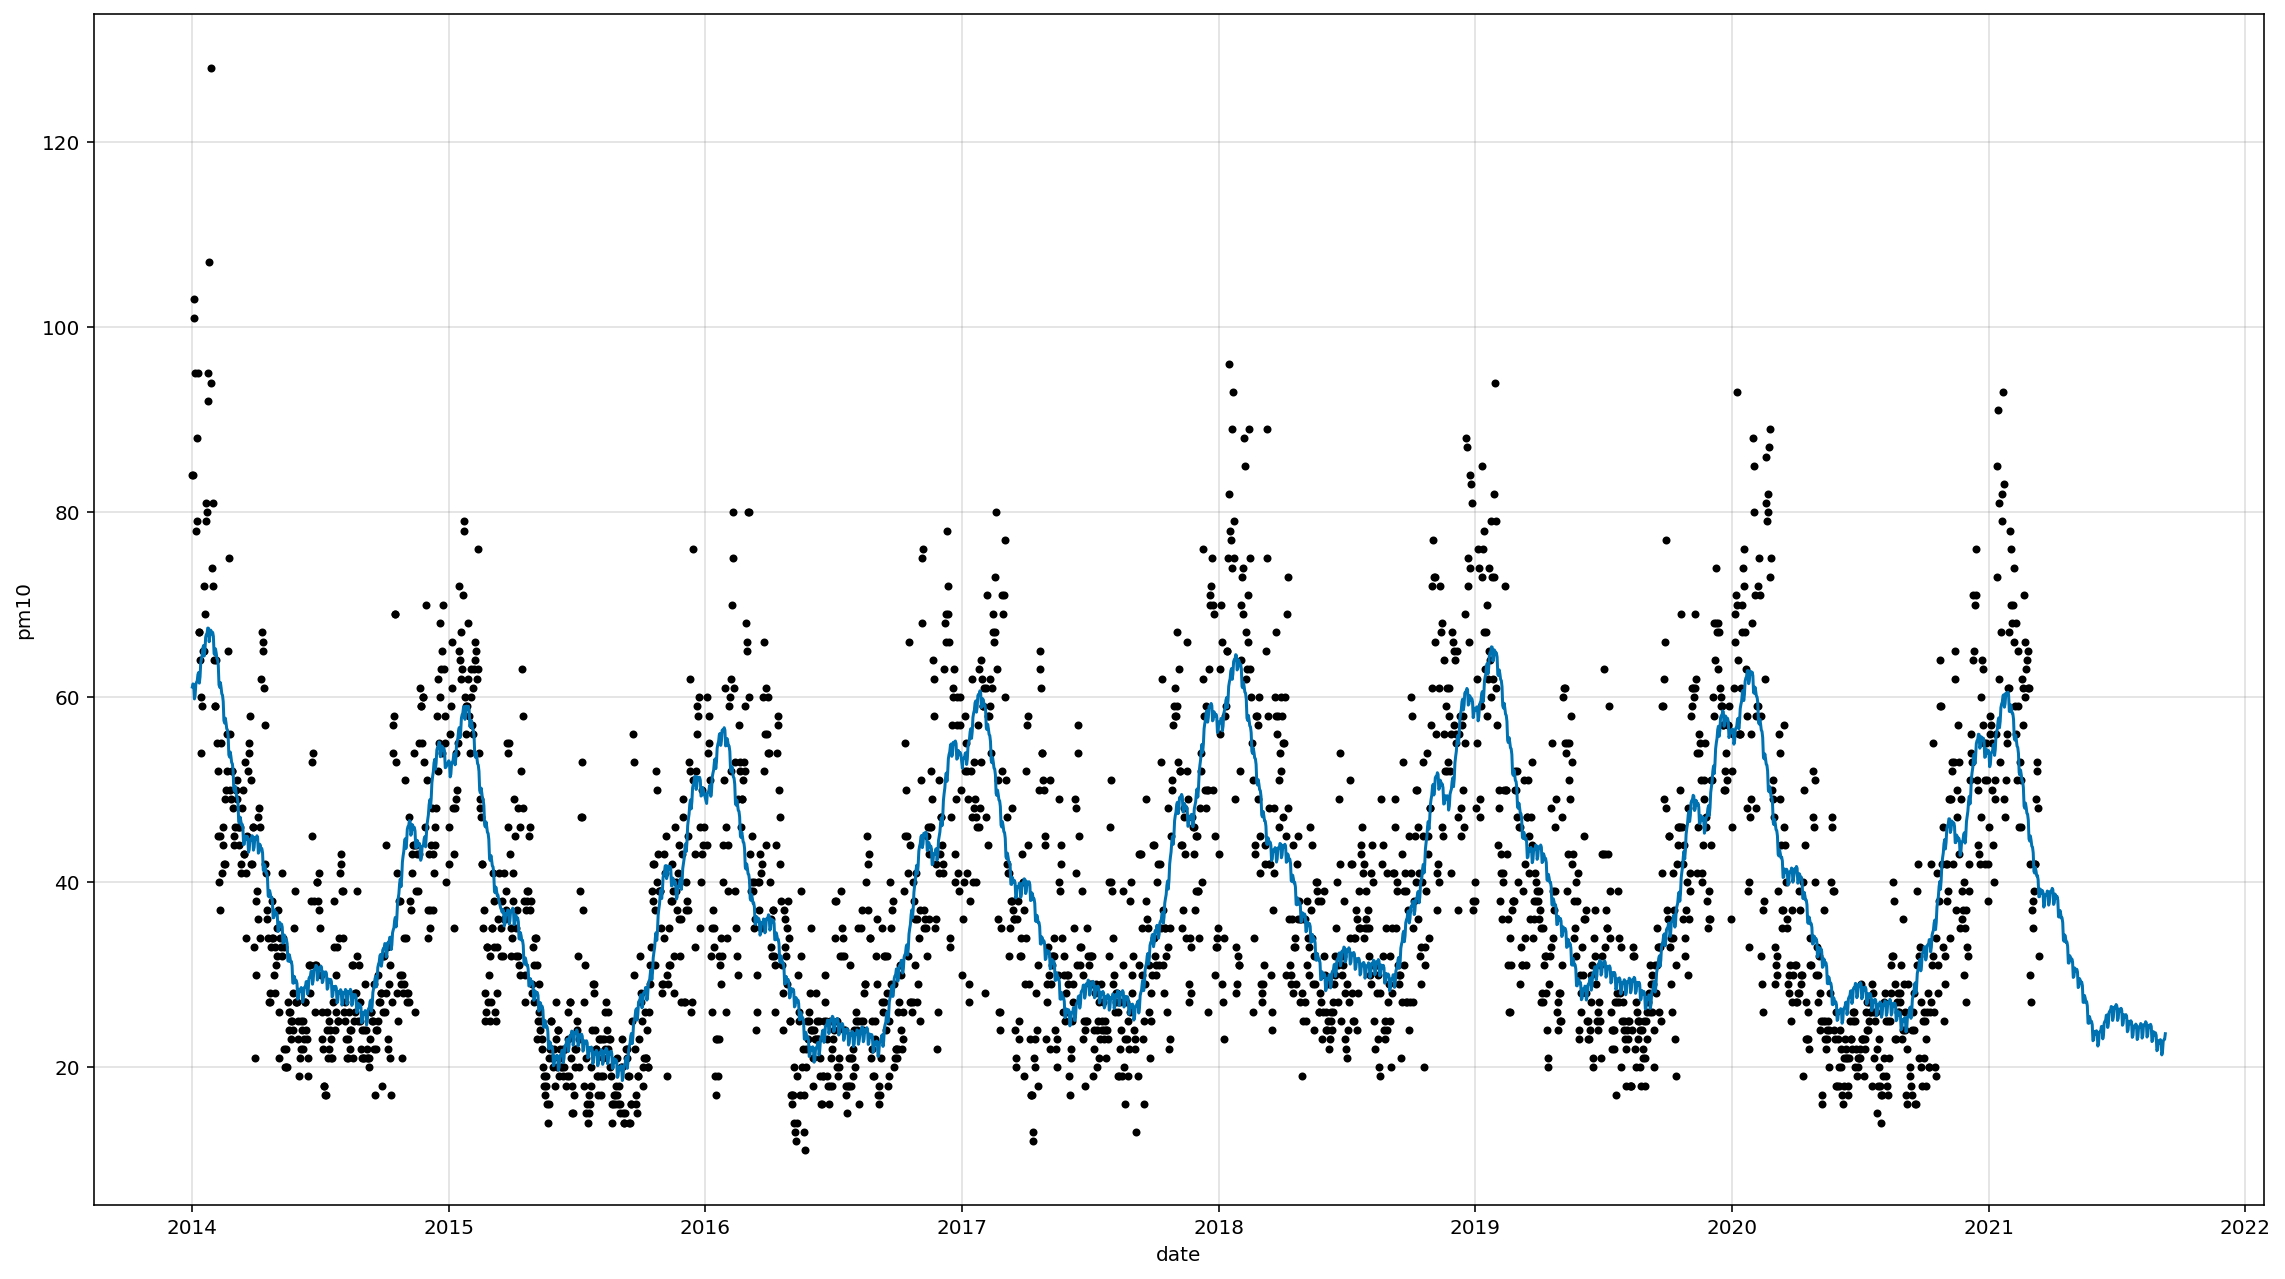

In [26]:
fig=model.plot(forecast, uncertainty=False, figsize=(16, 9), xlabel='date', ylabel=y_col)

### plot weekly and yearly trend

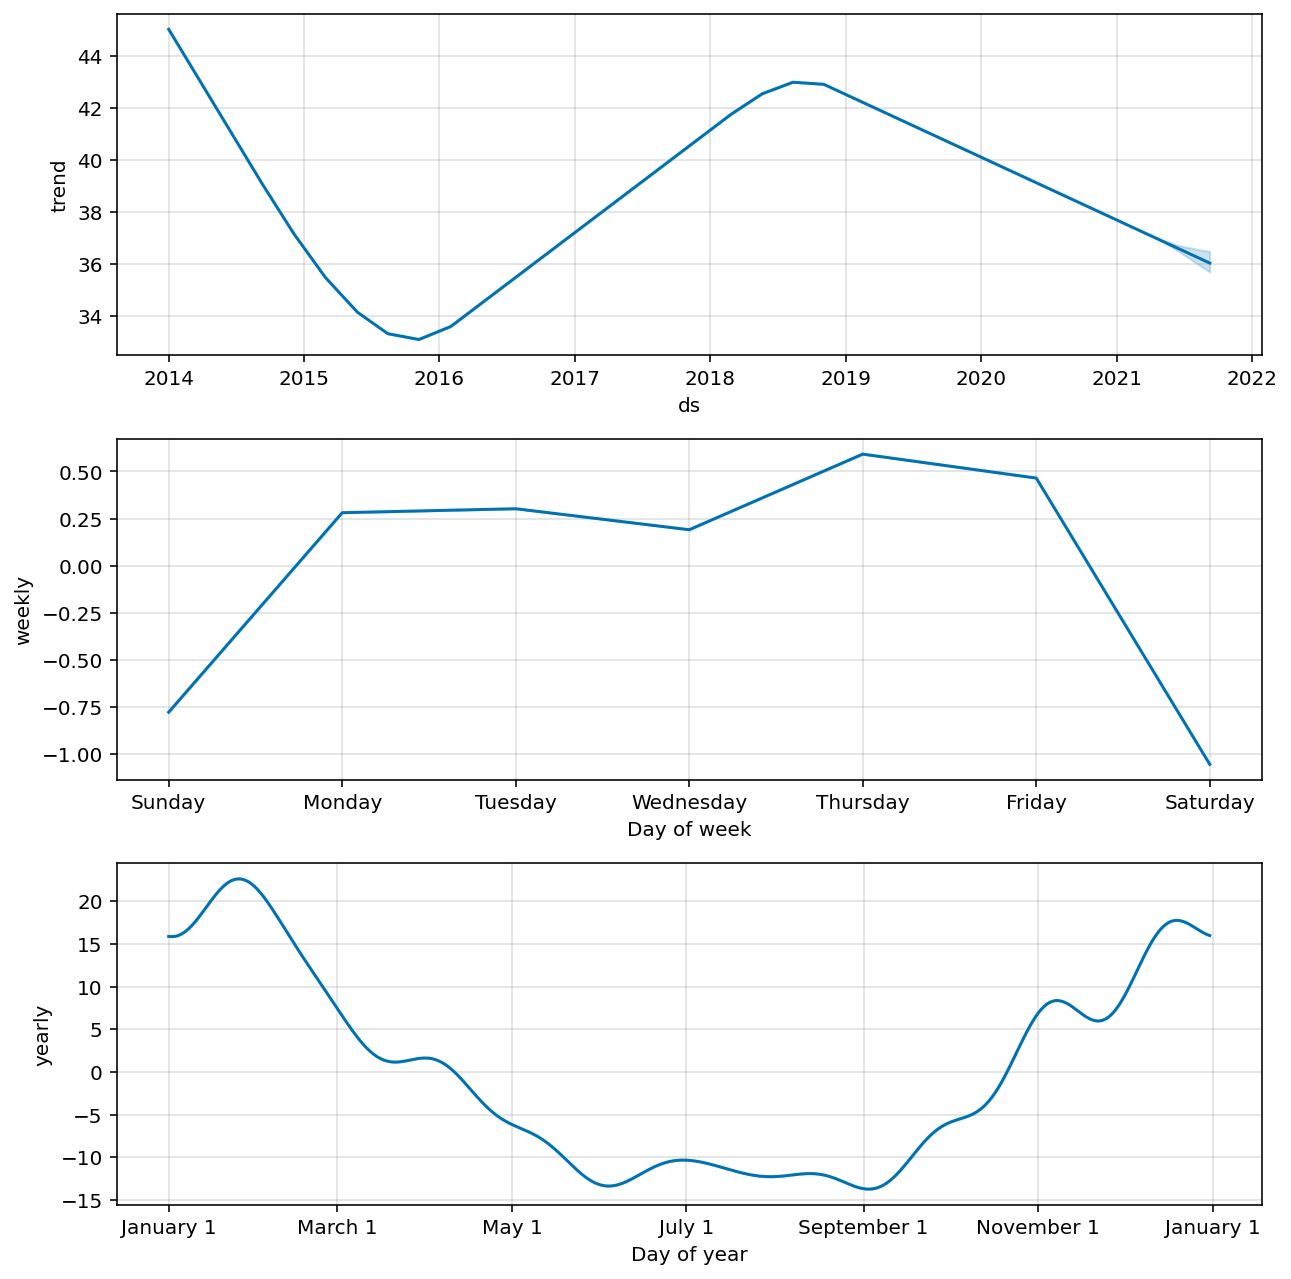

In [27]:
fig=model.plot_components(forecast)